In [1]:
!git clone --quiet --recursive https://github.com/mnseong/WCRC-Localization.git

In [2]:
%cd WCRC-Localization

/content/WCRC-Localization


In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 56.6 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
from core import extract, match, image_retrieval, reconstruction, visualization
from core.visualization import plot_images, read_image
from core.localize_sfm import QueryLocalizer, pose_from_cluster
from utils import viz_3d
from pathlib import Path
import core.localize_sfm
import pycolmap
import numpy as np

In [6]:
images = Path('/content/drive/MyDrive/datasets/pnu_me/')
outputs = Path('/content/drive/MyDrive/outputs/pnu_me/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_pairs_re = outputs / 'pairs-sfm-retrieval.txt'
sfm_dir = outputs / 'sfm'
local_features = outputs / 'local_features.h5'
global_features = outputs / 'global_features.h5'
local_features_q = outputs / 'local_features_q.h5'
global_features_q = outputs / 'global_features_q.h5'
matches = outputs / 'matches.h5'
loc_matches = outputs / 'loc_matches.h5'

global_feature_conf = extract.configs['cosplace']
local_feature_conf = extract.configs['disk']
matcher_conf = match.configs['NN']

In [7]:
references = [str(p.relative_to(images)) for p in (images / 'mapping/').iterdir()]
print(len(references), "mapping images")

381 mapping images


In [8]:
extract.main(global_feature_conf, images, image_list=references, feature_path=global_features)

[2023/11/19 13:45:30 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'cosplace'},
 'output': 'global-feats-cosplace',
 'preprocessing': {'resize_max': 1024}}
/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/gmberton/CosPlace/zipball/main" to /root/.cache/torch/hub/main.zip


Returning CosPlace model with backbone: ResNet50 with features dimension 2048


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 34.2MB/s]
Downloading: "https://github.com/gmberton/CosPlace/releases/download/v1.0/ResNet50_2048_cosplace.pth" to /root/.cache/torch/hub/checkpoints/ResNet50_2048_cosplace.pth
100%|██████████| 106M/106M [00:02<00:00, 54.6MB/s]
100%|██████████| 381/381 [00:16<00:00, 22.85it/s]
[2023/11/19 13:46:04 hloc INFO] Finished exporting features.


PosixPath('/content/drive/MyDrive/outputs/pnu_me/global_features.h5')

In [9]:
extract.main(local_feature_conf, images, image_list=references, feature_path=local_features)

[2023/11/19 13:46:04 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
Downloading: "https://raw.githubusercontent.com/cvlab-epfl/disk/master/depth-save.pth" to /root/.cache/torch/hub/checkpoints/depth-save.pth
100%|██████████| 4.17M/4.17M [00:00<00:00, 16.6MB/s]
100%|██████████| 381/381 [00:10<00:00, 35.87it/s]
[2023/11/19 13:46:17 hloc INFO] Finished exporting features.


PosixPath('/content/drive/MyDrive/outputs/pnu_me/local_features.h5')

In [10]:
image_retrieval.main(descriptors=global_features, output=sfm_pairs_re, num_matched=20)

[2023/11/19 13:46:17 hloc INFO] Extracting image pairs from a retrieval database.


1
2
3
4
5
7


[2023/11/19 13:46:29 hloc INFO] Found 7620 pairs.


In [11]:
match.main(matcher_conf, sfm_pairs_re, features=local_features, matches=matches);

[2023/11/19 13:46:29 hloc INFO] Matching local features with configuration:
{'model': {'do_mutual_check': True,
           'name': 'nearest_neighbor',
           'ratio_threshold': 0.8},
 'output': 'matches-NN-mutual-ratio.8'}
100%|██████████| 4921/4921 [01:54<00:00, 42.90it/s]
[2023/11/19 13:48:23 hloc INFO] Finished exporting matches.


In [12]:
model = reconstruction.main(sfm_dir, images, sfm_pairs_re, local_features, matches, image_list=references)
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

[2023/11/19 13:48:23 hloc INFO] Creating an empty database...
[2023/11/19 13:48:23 hloc INFO] Importing images into the database...
[2023/11/19 13:48:25 hloc INFO] Importing features into the database...
100%|██████████| 381/381 [00:00<00:00, 484.86it/s]
[2023/11/19 13:48:26 hloc INFO] Importing matches into the database...
100%|██████████| 7620/7620 [02:04<00:00, 61.07it/s]  
[2023/11/19 13:50:31 hloc INFO] Performing geometric verification of the matches...
[2023/11/19 13:50:34 hloc INFO] Running 3D reconstruction...
[2023/11/19 13:52:45 hloc INFO] Reconstructed 7 model(s).
[2023/11/19 13:52:45 hloc INFO] Largest model is #1 with 48 images.
[2023/11/19 13:52:45 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 48
	num_cameras = 48
	num_points3D = 2016
	num_observations = 13606
	mean_track_length = 6.74901
	mean_observations_per_image = 283.458
	mean_reprojection_error = 0.750404
	num_input_images = 381


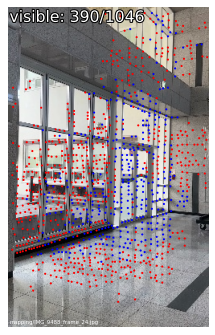

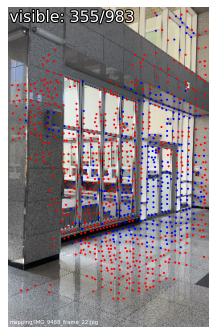

In [13]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)

wget: missing URL
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


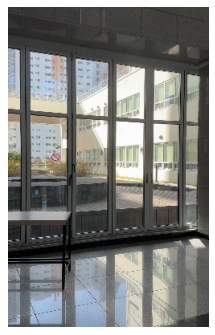

In [14]:
query = "query/IMG_9488_frame_17.jpg"
!mkdir -p $images/query && wget $url -O $images/$query -q
plot_images([read_image(images / query)], dpi=75)

In [15]:
references_registered = [model.images[i].name for i in model.reg_image_ids()]

In [16]:
query_global_features = extract.main(global_feature_conf, images, image_list=[query], feature_path=global_features_q)
#query_local_features = extract.main(local_feature_conf, images, image_list=[query], feature_path=local_features_q)

[2023/11/19 13:52:47 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'cosplace'},
 'output': 'global-feats-cosplace',
 'preprocessing': {'resize_max': 1024}}
Using cache found in /root/.cache/torch/hub/gmberton_CosPlace_main


Returning CosPlace model with backbone: ResNet50 with features dimension 2048


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]
[2023/11/19 13:52:48 hloc INFO] Finished exporting features.


In [17]:
extract.main(local_feature_conf, images, image_list=[query], feature_path=local_features, overwrite=True)

[2023/11/19 13:52:48 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
100%|██████████| 1/1 [00:00<00:00,  7.26it/s]
[2023/11/19 13:52:49 hloc INFO] Finished exporting features.


PosixPath('/content/drive/MyDrive/outputs/pnu_me/local_features.h5')

In [18]:
image_retrieval.main(descriptors=query_global_features,
                     query_list=[query],
                     output=loc_pairs,
                     db_list=references_registered,
                     db_descriptors=global_features,
                     num_matched=20)

[2023/11/19 13:52:49 hloc INFO] Extracting image pairs from a retrieval database.


2
3
4
5
7


[2023/11/19 13:52:49 hloc INFO] Found 20 pairs.


In [19]:
loc_matches = match.main(matcher_conf, loc_pairs, features=local_features, matches=loc_matches);

[2023/11/19 13:52:49 hloc INFO] Matching local features with configuration:
{'model': {'do_mutual_check': True,
           'name': 'nearest_neighbor',
           'ratio_threshold': 0.8},
 'output': 'matches-NN-mutual-ratio.8'}
100%|██████████| 20/20 [00:00<00:00, 42.20it/s]
[2023/11/19 13:52:49 hloc INFO] Finished exporting matches.


In [20]:
file_name = '/content/drive/MyDrive/outputs/pnu_me/pairs-loc.txt'

retrieved_db_list = []

with open(file_name, 'r') as file:
    for line in file:
        parts = line.strip().split(' ')
        if len(parts) == 2:
            retrieved_db_list.append(parts[1])

In [21]:
camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in retrieved_db_list]

In [22]:
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)

In [23]:
ret, log = pose_from_cluster(
        localizer=localizer,
        qname=query,
        query_camera=camera,
        db_ids=ref_ids,
        features_path=local_features,
        matches_path=loc_matches,
    )

found 21/22 inlier correspondences.


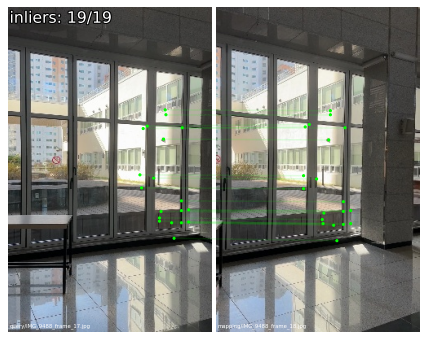

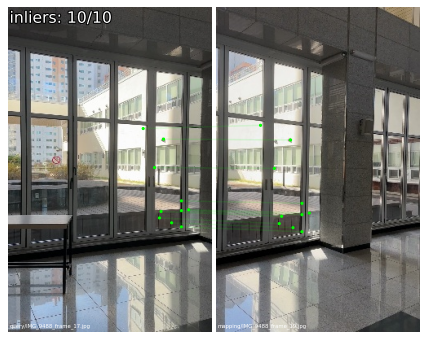

In [24]:
print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

In [25]:
pose = pycolmap.Image(tvec=ret['tvec'], qvec=ret['qvec'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query, fill=True)
# visualize 2D-3D correspodences
inl_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[ret['inliers']]])
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()